In [1]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras.datasets import boston_housing

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


<br>
<br>

# 데이터 로드

In [2]:
# 보스턴 하우징 데이터를 로드
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
# 훈련셋 크기
train_data.shape


(404, 13)

In [4]:
# 훈련셋 목표 크기
train_targets.shape


(404,)

In [5]:
# 테스트셋 크기
test_data.shape


(102, 13)

In [6]:
# 테스트셋 목표 크기
test_targets.shape


(102,)

In [7]:
# 첫 번째 훈련셋 출력
train_data[0]


array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [8]:
# 첫 번째 훈련셋 목표 출력
train_targets[0]


15.2

훈련셋에는 다음과 같이 집 가격에 영향을 미치는 13개의 입력 항목이 있습니다. 

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft
3. INDUS - proportion of non-retail business acres per town
4. CHAS - Charles River dummy variable (1 if tract bounds river; else 0)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PT - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population

출력 목표는 집의 가격으로 1000$ 기준입니다.

<br>
<br>

# 전처리

In [9]:
# 0축인 각 데이터를 기준으로 13개 항목의 평균을 구함
# 평균을 뺀 값에 표준편차로 나누면 모든 데이터가 같은 범위를 가짐
x_train = train_data
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

# 훈련셋의 평균과 표준편차로 테스트셋을 정규화해서 기준을 통일해야 함
x_test = test_data
x_test -= mean
x_test /= std

# 목표값은 전처리 없이 그대로 사용
y_train = train_targets
y_test = test_targets

신경망의 입력들이 범위가 각각 다르면 학습 효과가 떨어집니다. 그래서 같은 스케일로 통일할 필요가 있습니다. 이런 방법에는 최대값과 최소값을 사용하는 정규화(Normalization)와 평균과 표준편차 기반의 표준화(Standardization)가 있습니다. 여기서는 표준화를 적용하였습니다.
<br>
<br>
<br>

In [10]:
# 첫 번째 훈련셋 출력
x_train[0]


array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [11]:
# 첫 번째 훈련셋 목표 출력
y_train[0]


15.2

<br>
<br>

# 모델 생성

In [12]:
def build_model():

    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 마지막 레이어에 활성화 함수 없음
    
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    
    return model

이전 분류 문제에서는 마지막 레이어의 활성화 함수가 sigmoid나 softmax였습니다. 하지만 회귀에서는 출력이 0~1 사이가 아닙니다. 그래서 활성화 함수 없이 어떠한 실수라도 가능하도록 합니다.

또한 이번 예제는 회귀 문제이기 때문에 손실 함수로 MSE(Mean Squre Error)를 사용하였습니다. 마찬가지로 측정 항목은 MAE(Mean Absolute Error)로 설정하였습니다.

<br>
<br>

# 훈련 및 평가

지금까지 다룬 예제에서는 검증셋을 한번만 분리하고 학습을 진행하였습니다. 하지만 이번 훈련셋은 샘플의 수가 404개로 매우 적습니다. 검증셋 역시 많이 사용할 수가 없기 때문에, 과대적합이 되는 부분을 효과적으로 판단하기가 어렵습니다. 

이런 문제점을 보완하기 위해서 K-폴드 교차 검증(K-Fold Cross Validation)을 적용하겠습니다. 전체 훈련셋을 k개로 분리하여 각각 훈련셋과 검증셋을 만들고 이를 반복적으로 돌아가며 사용합니다. 이렇게 k번 훈련을 하고 그 검증 결과를 평균을 내어 확인합니다.
<br>
<br>
<br>

In [13]:
k = 4
val_samples_num = len(x_train) // k
epochs_num = 200
mae_list = []

# k번 교차 검증 반복
for i in range(k):
    print('Current fold in progress :', i)
    
    # 검증 데이터 분할
    # k 위치에 있는 데이터를 검증 샘플 수만큼 잘라냄
    x_val = x_train[i * val_samples_num:(i + 1) * val_samples_num]
    y_val = y_train[i * val_samples_num:(i + 1) * val_samples_num]

    # 훈련 데이터 분할
    # 검증 데이터 부분을 제외하고 합침
    x_train_new = np.concatenate(
        [x_train[:i * val_samples_num],
         x_train[(i + 1) * val_samples_num:]],
        axis=0)
    y_train_new = np.concatenate(
        [y_train[:i * val_samples_num],
         y_train[(i + 1) * val_samples_num:]],
        axis=0)

    # 모델 생성
    model = build_model()

    # 훈련 시작
    # verboss가 0이면 진행 상황 출력 안함
    history = model.fit(x_train_new, 
                        y_train_new,
                        epochs=epochs_num, 
                        batch_size=1,
                        validation_data=(x_val, y_val),
                        verbose=0)
    
    # MAE를 리스트에 추가
    mae = history.history['val_mean_absolute_error']
    mae_list.append(mae)
    

Current fold in progress : 0
Current fold in progress : 1
Current fold in progress : 2
Current fold in progress : 3


In [14]:
# 각 에폭마다 k개의 MAE가 존재하고, 이를 평균으로 계산하여 검증에 사용
mae_average = [np.mean([x[i] for x in mae_list]) for i in range(epochs_num)]

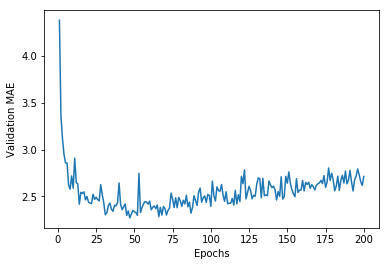

In [15]:
epochs = range(1, len(mae_average) + 1)

plt.plot(epochs, mae_average)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()


MAE가 급격하게 떨어져서 그래프 하단의 변화량을 알아보기가 어렵습니다. 앞부분인 10개의 에폭 부분을 삭제해 보겠습니다.
<br>
<br>
<br>

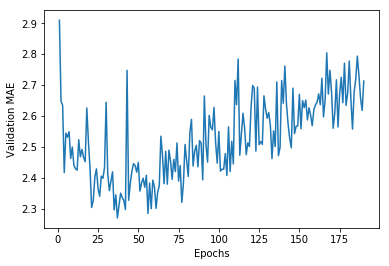

In [16]:
mae_average_new = mae_average[10:]
epochs = range(1, len(mae_average_new) + 1)

plt.plot(epochs, mae_average_new)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()


이번에는 그래프의 변화가 너무 커서 눈에 잘 들어오지 않습니다. 지수 이동 평균(exponential moving average)으로 그래프를 좀 더 부드럽게 변환하겠습니다. 이전 위치에서 다음 위치 방향으로 조금씩만 움직이는 방법입니다.
<br>
<br>
<br>

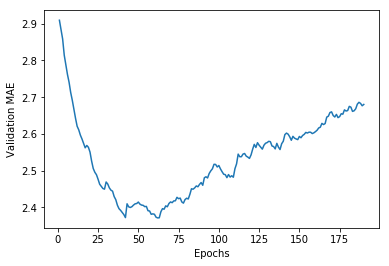

In [17]:
def convert_ema(points, factor=0.9):
    
    points_new = []

    for point in points:
        if points_new:
            # 이전 위치가 있으면 factor 비율만큼만 조금씩 다음 위치로 이동
            previous = points_new[-1]
            points_new.append(previous * factor + point * (1 - factor))
        else:
            # 첫 번째 위치면 그냥 추가
            points_new.append(point)
        
    return points_new

mae_average_new = convert_ema(mae_average[10:])
epochs = range(1, len(mae_average_new) + 1)

plt.plot(epochs, mae_average_new)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()


이제 그래프의 패턴이 확실하게 보입니다. 대략 60번째 에폭부터 검증셋의 MAE가 다시 증가하기 시작합니다. 과대적합을 피하기 위해 에폭을 60으로 수정하고 다시 학습을 합니다.
<br>
<br>
<br>

In [18]:
model = build_model()
model.fit(x_train, y_train, epochs=60, batch_size=16)


Epoch 1/60
404/404 [==============================] - 0s 639us/step - loss: 474.0111 - mean_absolute_error: 19.7101
Epoch 2/60
404/404 [==============================] - 0s 94us/step - loss: 283.9133 - mean_absolute_error: 14.5997
Epoch 3/60
404/404 [==============================] - 0s 109us/step - loss: 112.6100 - mean_absolute_error: 8.4548
Epoch 4/60
404/404 [==============================] - 0s 104us/step - loss: 43.6454 - mean_absolute_error: 4.9503
Epoch 5/60
404/404 [==============================] - 0s 109us/step - loss: 28.7252 - mean_absolute_error: 3.9558
Epoch 6/60
404/404 [==============================] - 0s 104us/step - loss: 23.1903 - mean_absolute_error: 3.4741
Epoch 7/60
404/404 [==============================] - 0s 106us/step - loss: 20.0986 - mean_absolute_error: 3.2081
Epoch 8/60
404/404 [==============================] - 0s 104us/step - loss: 18.1793 - mean_absolute_error: 3.0394
Epoch 9/60
404/404 [==============================] - 0s 106us/step - loss: 16.4094 

In [19]:
# 모델 저장
model.save('./model/house_price_model.h5')

<br>
<br>

# 테스트셋 확인

In [20]:
# 저장된 모델 파일 로드
model = models.load_model('./model/house_price_model.h5')

In [21]:
# 테스트셋 평가
results = model.evaluate(x_test, y_test)
results


102/102 [==============================] - 0s 755us/step


[21.2233787985409, 2.898613733403823]

테스트셋의 MAE가 2.9정도 나왔습니다. 1이 1000달러이니까 예측한 집값이 2900달러 사이로 오차가 발생합니다.
<br>
<br>
<br>

In [22]:
# 테스트셋 예측
results = model.predict(x_test)
results


array([[ 9.488937],
       [19.270061],
       [22.015099],
       [34.48477 ],
       [25.209408],
       [20.186125],
       [27.46976 ],
       [21.538265],
       [20.473083],
       [23.785065],
       [19.493122],
       [17.360668],
       [16.278185],
       [42.440033],
       [20.698235],
       [19.438725],
       [26.12661 ],
       [18.633827],
       [20.370628],
       [29.363077],
       [12.093613],
       [16.130497],
       [21.97601 ],
       [15.835922],
       [20.338072],
       [25.978556],
       [30.045477],
       [29.25678 ],
       [12.678527],
       [19.947788],
       [19.703615],
       [16.339949],
       [33.098946],
       [24.006245],
       [17.451866],
       [ 9.22693 ],
       [16.656586],
       [18.91994 ],
       [22.367086],
       [25.797804],
       [29.747622],
       [27.498491],
       [15.88619 ],
       [41.81327 ],
       [28.741608],
       [25.230164],
       [27.039915],
       [17.368298],
       [25.398941],
       [22.442474],


In [23]:
max(results)


array([51.729385], dtype=float32)

In [24]:
min(results)


array([8.052691], dtype=float32)

예측한 집값을 보면 최소 8000달러에서 최대 51000달러 사이입니다. 1970년대 조사한 자료인 것을 감안하면, 지금보다 당시의 부동산 가격이 상당히 저렴했던 것을 알 수 있습니다.